<a href="https://colab.research.google.com/github/mikeacquaviva/APS360-Leukaemia-Classification/blob/main/cnn_leukemia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
import time
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
preprocessed_data_dir = ("/content/gdrive/MyDrive/APS360/pre-processed")
classes = ['benign', 'early', 'pre', 'pro']
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])
data_full = datasets.ImageFolder(preprocessed_data_dir, transform = data_transform)
print(len(data_full))
train  = len(data_full)*0.6 
train = int(train) 
print(train)

val  = (len(data_full) - train)*0.5
val = int(val)
print(val)

train_full, val_full, test_full = random_split(data_full, [train, val, val], generator=torch.Generator().manual_seed(0)) #adding seed such that it produces the same data set each time
# print out some data stats
print('Num training images: ', (train))
print('Num validation images: ', (val))
print('Num test images: ', (val))

2954
1772
591
Num training images:  1772
Num validation images:  591
Num test images:  591


In [ ]:
preprocessed_data_dir = ("/content/gdrive/MyDrive/APS360/pre-processed")
classes = ['benign', 'early', 'normal', 'pre', 'pro']
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])
data_full = datasets.ImageFolder(preprocessed_data_dir, transform = data_transform)
print(len(data_full))
train  = len(data_full)*0.6
train = int(train) 
print(train)

val  = len(data_full)*0.2
val = int(val)
print(val)

train_full, val_full, test_full = random_split(data_full, [train, val, val], generator=torch.Generator().manual_seed(0)) #adding seed such that it produces the same data set each time
# print out some data stats
print('Num training images: ', (train))
print('Num validation images: ', (val))
print('Num test images: ', (val))

3060
1836
612
Num training images:  1836
Num validation images:  612
Num test images:  612


In [ ]:
data_dir = ("/content/gdrive/MyDrive/APS360/baseline/svm_images")
classes = ['benign', 'early', 'normal', 'pre', 'pro']
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])
data = datasets.ImageFolder(data_dir, transform = data_transform)
print(len(data))
train, val, test = random_split(data, [600, 105,  105], generator=torch.Generator().manual_seed(0)) #adding seed such that it produces the same data set each time
# print out some data stats
print('Num training images: ', len(train))
print('Num validation images: ', len(val))
print('Num test images: ', len(test))

In [6]:
# define dataloader parameters
batch_size = 32
num_workers = 1

# prepare data loaders
train_loader = 0
val_loader = 0
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_full, batch_size=27, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_full, batch_size=27, 
                                          num_workers=num_workers, shuffle=True)
print(len(train_loader))


66


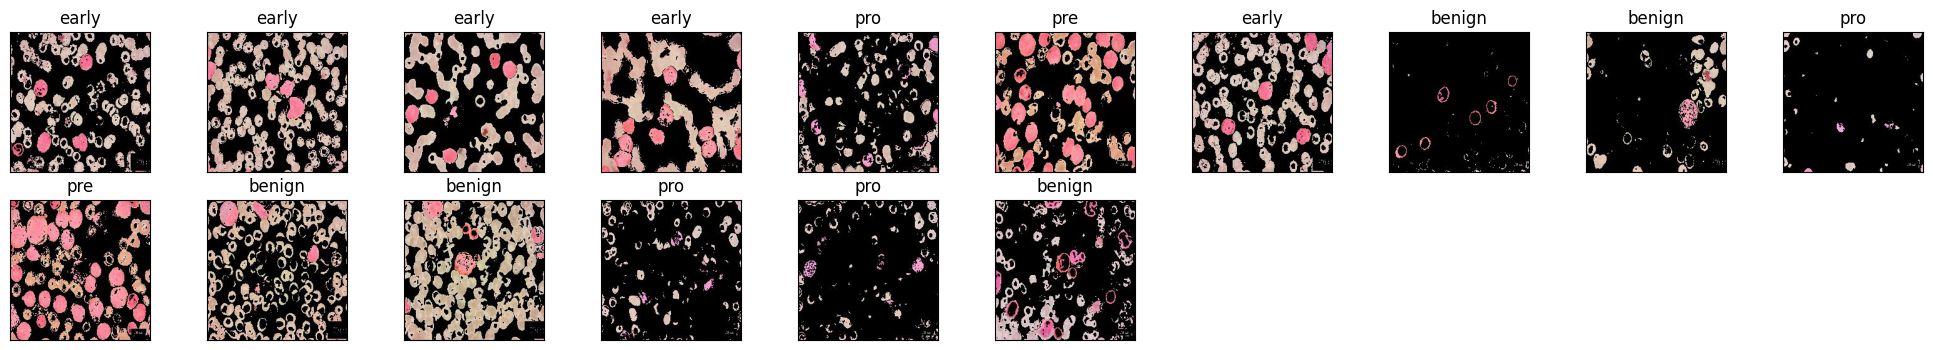

In [7]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(0) # set the random seed

In [9]:
def get_data_loader(target_classes, batch_size):
  classes = ['benign', 'early', 'pre', 'pro']
  

In [ ]:
def leakyrelu(x):
  if(x>=0):
    return x
  else:
    return 0.01*x  

In [10]:
#Convolutional Neural Network Architecture
class CNN_leaky(nn.Module):
    def __init__(self):
        super(CNN_leaky, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(3, 5, 3) #in_channels, out_chanels, kernel_size, 
        #convolution neural network and have to specify the number of inner terminals and define the kernel size.
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride  
        #shift the entire image by 2 kernsls
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 53 * 53, 32) 
        #self.fc2 = nn.Linear(64, 32) 
        self.fc3 = nn.Linear(32, 5) #which letter from a-i as the options for output, so 9 outputs 

    def forward(self, x):
        y = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(y))) #flatten the layer
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [11]:
#Convolutional Neural Network Architecture
class CNN_MNISTClassifier(nn.Module):
    def __init__(self):
        super(CNN_MNISTClassifier, self).__init__()
        self.name = "cnn"
        self.conv1 = nn.Conv2d(3, 5, 3) #in_channels, out_chanels, kernel_size, 
        #convolution neural network and have to specify the number of inner terminals and define the kernel size.
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride  
        #shift the entire image by 2 kernsls
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(10 * 53 * 53, 32) 
        #self.fc2 = nn.Linear(64, 32) 
        self.fc3 = nn.Linear(32, 5) #which letter from a-i as the options for output, so 9 outputs 

    def forward(self, x):
        y = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(y))) #flatten the layer
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')

Convolutional Neural Network Architecture Done


In [12]:
#helper function; label, evaluate
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [13]:
def get_accuracy(model, data):

    correct = 0
    total = 0
    for imgs, labels in data:
        #print(imgs.size())
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [14]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [15]:
from torch.utils.data import DataLoader, Dataset
def train(model, batch_size, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    epoch = 0 # the number of iterations
    n = 0
    
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            #print(labels)
            n+=1
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            
        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model,train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation err: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   losses[epoch],
                   val_acc[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        print(epoch, "acc:", train_acc[epoch])
    print("train_loader: ", n)     
    #draw_confusion_matrix(predicted_labels, actual_labels)
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [16]:
def accuracy_class(model):
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  true_pos = {classname: 0 for classname in classes}
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1
    #draw_confusion_matrix(prediction, correct_pred)
  #print accuracy for each class
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for {classname:5s} : {accuracy:.5f} %')

Epoch 1: Train acc: 0.4497742663656885, Train loss: 0.04112263768911362 |Validation err: 0.4230118443316413
0 acc: 0.4497742663656885
Epoch 2: Train acc: 0.6450338600451467, Train loss: 0.02258559875190258 |Validation err: 0.5820642978003384
1 acc: 0.6450338600451467
Epoch 3: Train acc: 0.8781038374717833, Train loss: 0.01837645098567009 |Validation err: 0.7698815566835872
2 acc: 0.8781038374717833
Epoch 4: Train acc: 0.9170428893905191, Train loss: 0.009012428112328053 |Validation err: 0.7715736040609137
3 acc: 0.9170428893905191
Epoch 5: Train acc: 0.9853273137697517, Train loss: 0.004172708373516798 |Validation err: 0.8138747884940778
4 acc: 0.9853273137697517
Epoch 6: Train acc: 0.9915349887133182, Train loss: 0.0016217270167544484 |Validation err: 0.8291032148900169
5 acc: 0.9915349887133182
Epoch 7: Train acc: 0.9221218961625283, Train loss: 0.011006543412804604 |Validation err: 0.7834179357021996
6 acc: 0.9221218961625283
Epoch 8: Train acc: 0.9858916478555305, Train loss: 2.829

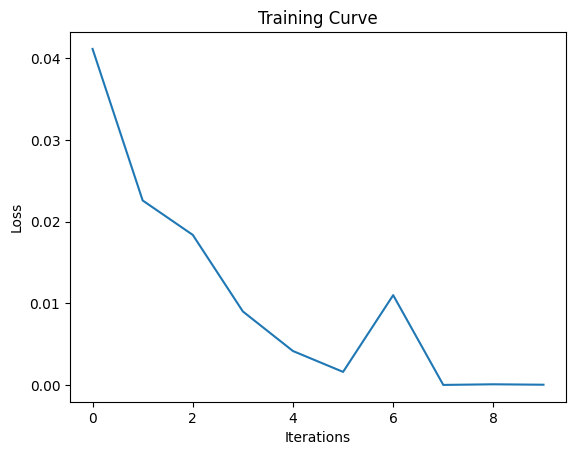

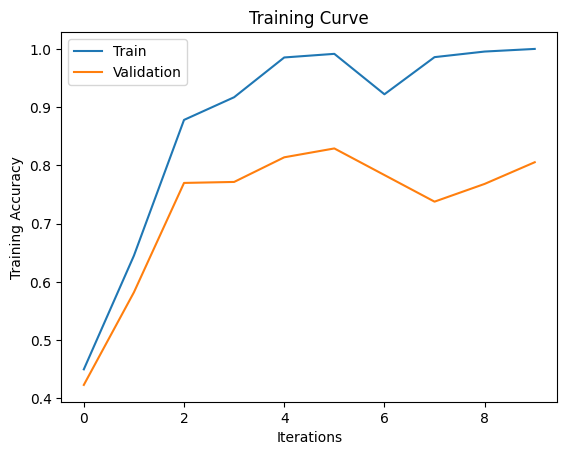

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.805414551607445


In [17]:
#with full pre-processed data set
more_net = CNN_leaky()

train(more_net, batch_size = 32, learning_rate = 0.01, num_epochs=10)

In [18]:
test_loader = torch.utils.data.DataLoader(test_full, batch_size=27, shuffle=True)
accuracy_class(more_net)

Accuracy for benign : 56.75676 %
Accuracy for early : 91.00000 %
Accuracy for pre   : 84.88372 %
Accuracy for pro   : 95.37037 %


In [19]:
test_accuracy = get_accuracy(more_net, test_loader)
print("test accuracy:", test_accuracy)

test accuracy: 0.8358714043993232


<Figure size 500x400 with 0 Axes>

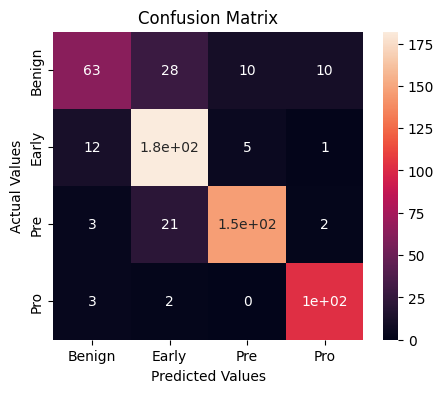

In [26]:
predicted_labels = np.array([])
actual_labels = np.array([])
for x, y in test_loader:
    predicted_labels = np.append(predicted_labels, more_net(x).argmax(dim=1).numpy())
    actual_labels = np.append(actual_labels, y.numpy())

draw_confusion_matrix(predicted_labels, actual_labels)

In [27]:
print(classification_report(actual_labels, predicted_labels, target_names=classes))

              precision    recall  f1-score   support

      benign       0.78      0.57      0.66       111
       early       0.78      0.91      0.84       200
         pre       0.91      0.85      0.88       172
         pro       0.89      0.95      0.92       108

    accuracy                           0.84       591
   macro avg       0.84      0.82      0.82       591
weighted avg       0.84      0.84      0.83       591



#Model 2: With 5 classes 

This includes the healthy classes.

Epoch 1: Train acc: 0.47167755991285404, Train loss: 0.03792120350731744 |Validation err: 0.45588235294117646
0 acc: 0.47167755991285404
Epoch 2: Train acc: 0.7194989106753813, Train loss: 0.025868504135696975 |Validation err: 0.6699346405228758
1 acc: 0.7194989106753813
Epoch 3: Train acc: 0.8082788671023965, Train loss: 0.028559907718941017 |Validation err: 0.7369281045751634
2 acc: 0.8082788671023965
Epoch 4: Train acc: 0.8698257080610022, Train loss: 0.013587697788521095 |Validation err: 0.8088235294117647
3 acc: 0.8698257080610022
Epoch 5: Train acc: 0.9357298474945533, Train loss: 0.01319780945777893 |Validation err: 0.8006535947712419
4 acc: 0.9357298474945533
Epoch 6: Train acc: 0.7489106753812637, Train loss: 0.022090421782599554 |Validation err: 0.6830065359477124
5 acc: 0.7489106753812637
Epoch 7: Train acc: 0.8801742919389978, Train loss: 0.023190098780172842 |Validation err: 0.738562091503268
6 acc: 0.8801742919389978
Epoch 8: Train acc: 0.9302832244008714, Train loss: 0.0

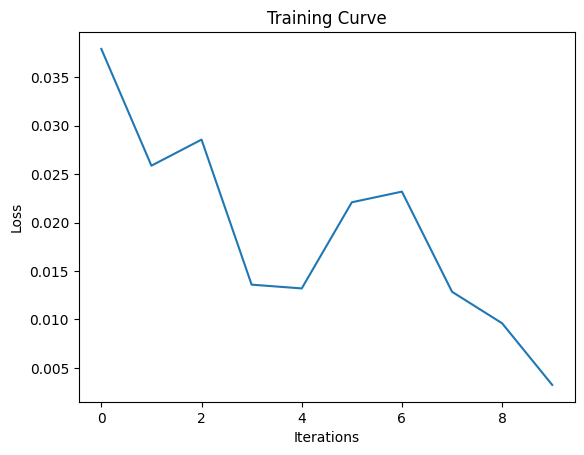

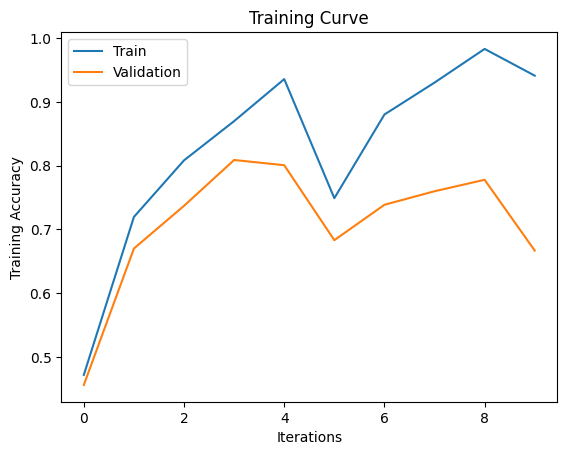

Final Training Accuracy: 0.9411764705882353
Final Validation Accuracy: 0.6666666666666666


In [ ]:
#lowering learning rate
more_net = CNN_leaky()

train(more_net, batch_size = 27, learning_rate = 0.008, num_epochs=10)

In [ ]:
test_accuracy = get_accuracy(more_net, test_loader)
print("test accuracy:", test_accuracy)

test accuracy: 0.7140522875816994


In [ ]:
test_loader = torch.utils.data.DataLoader(test_full, batch_size=27, shuffle=True)
accuracy_class(more_net)

Accuracy for benign : 43.33333 %
Accuracy for early : 64.78873 %
Accuracy for normal : 44.00000 %
Accuracy for pre   : 97.15909 %
Accuracy for pro   : 72.22222 %


In [ ]:
def accuracy_class(model):
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  true_pos = {classname: 0 for classname in classes}
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1
  #print accuracy for each class
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for {classname:5s} : {accuracy:.5f} %')

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [25]:
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(predicted_labels, actual_labels):

    cm = confusion_matrix(actual_labels, predicted_labels)
    cm_df = pd.DataFrame(cm,index = ['Benign','Early', 'Pre', 'Pro'], 
                     columns = ['Benign','Early', 'Pre', 'Pro'])

    plt.figure(figsize=(5,4))
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [ ]:
more_net = CNN_leaky()

train(more_net, batch_size = 32, learning_rate = 0.01, num_epochs=100)
model_path = get_model_name(more_net.name, batch_size, 0.01, 100)
torch.save(more_net.state_dict(), model_path)

In [ ]:
model_path = get_model_name("Overfit Model", 32, 0.01, 100)
torch.save(more_net.state_dict(), model_path)

In [ ]:
model_path = get_model_name("Overfit Model", 32, 0.01, 100)
model_path = 'OverfitModel_bs32_lr0.01_epoch100'
model = CNN_leaky()
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
accuracy_class(model)

In [ ]:
test_loader = torch.utils.data.DataLoader(test, batch_size=27, shuffle=True)
test_accuracy = get_accuracy(model, test_loader)
print("test accuracy:", test_accuracy)

#Model 2: Doing with same Number of Epochs as in Progress Report

In [ ]:
more_net = CNN_leaky()

train(more_net, batch_size = 32, learning_rate = 0.01, num_epochs=10)

In [ ]:
accuracy_class(more_net)

In [ ]:
model_path = get_model_name("TenEpochs", batch_size, 0.01, 10)
torch.save(more_net.state_dict(), model_path)

In [ ]:
model = CNN_leaky()
model_path = get_model_name("TenEpochs", 32, 0.01, 10)
model.load_state_dict(torch.load(model_path))

In [ ]:
test_loader = torch.utils.data.DataLoader(test, batch_size=27, shuffle=True)
test_accuracy = get_accuracy(more_net, test_loader)
print("test accuracy:", test_accuracy)